# Introduction
In this file, spot light search MVPA is applied on Z-stat files from first level analysis I have done on naive space, ART applied images, with each stimuli giving one Z-stat image.

MPVA is applied for all voxels of the brain. For each participant, data is split into the number of runs, with data from one run is used for test, and the rest is used for training. 

## Observation
Brain on fire

# Trouble Shooting resutls
I checked the output from multi-class classifier performance (Neutral, Negative, Target), for which ROC value even for Radius=0 was above 0 for many regions. 
My tests showed that, the classifer labled all data to Target (chance level), however between Neutral & Negative it’s performance was above chance, resulting in ROC_AUC>.5
However, fMRI data has auto-correlation property, as a result the true null hypothesis testing should be done (permutation) not simply comparing the results with chance level=.5 (at subject leve)
Sklearn has a permutation_test_score function for permutation test, however it does not support multi-class. Therefore, I’m going to focus on two class here only (Neg/Target or Neg/Neu, or Neu+Neg/Target)


    

In [1]:
import numpy as np
import pandas as pd
import os.path as op
import matplotlib.pyplot as plt
import nibabel as nib
import itertools
import multiprocessing
from multiprocessing import Pool
from importlib import reload #import function "reload"
import sys

import warnings
warnings.filterwarnings("ignore")
import os
import glob
from glob import glob
from scipy.io import loadmat
import math
import timeit
from timeit import default_timer as timer

plt.style.use('classic')
%matplotlib inline

In [16]:
from MVPA_func import SpherePoints, SphereValue, LoadAllNii, MVPA_FeatureExtraction, MVPA_Classification, LoopiFeatureDict, multi_run_wrapperLoopiFeatureDict
from MVPA_func import LoopiFeatureDictPerm, multi_run_wrapperLoopiFeatureDictPerm

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#from sklearn.svm import LinearSVC

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

### Load subject list file

In [4]:
subj_list_file='C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/subj_simultaneous.txt'
subj_list=list()
f = open(subj_list_file, 'r')
line=f.readline()
while line:
    subj_list.append(line[0:-1])
    oldline=line
    line = f.readline()
subj_list.pop()
subj_list.append(oldline)
f.close()
Nsubj=len(subj_list)

### Load SPM.mat to extract experiment info
This cell loads spm.mat file for each participant and from the data, extracts the number of runs, the path for each stat file, etc

In [5]:
# NEW note: I need to change neg to sad & Fear, 3 December 2023
# note: I don't know why the last item is repeated! but it doesn't make a misatke

conditions=['Neu','Neg','Pos','Targ']
ZstatInfo=pd.DataFrame(columns=['Subj','Run','Folder']+conditions)
for subj in subj_list:
    #print('Participant: '+subj)
    # Zstat files and their condisitons are in SPM filesWe repeat loading in the dataframe to avoid dividing the onsets by 2 multiple times ...
    SubjSPMFolder='C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/MRI_data/Analysis/SPM/'+subj+'/3cond_dist2/'
    os.path.isdir(SubjSPMFolder)
    myZstat=[]
    
    iRuns = 0
    for myRun in os.listdir(SubjSPMFolder):
        ZstatInfotmp=pd.DataFrame(columns=ZstatInfo.columns,index=[0])
        ZstatInfotmp['Subj'][0]=subj
        
        RunSubjSPM=SubjSPMFolder+myRun+'/SPM.mat'
        ZstatInfotmp['Folder'][0]=SubjSPMFolder+myRun+'/'

        #print('   loading SPM.mat for '+myRun+'...')
        mat = loadmat(RunSubjSPM)
        mdata=mat['SPM'][0,0]
        ndata=mdata['Sess'][0,0]
        odata=ndata['U']
        pdata=odata['name'][0]
        ZstatNames=[pdata[i][0,0][0] for i in range(len(pdata))]
        myZstat.append(ZstatNames)

        ZstatInfotmp['Run'][0]=iRuns+1
        old_ind=len(myZstat[iRuns])+1 
        for iCond in reversed(conditions):    
            Start_ind=myZstat[iRuns].index(iCond+'_1')+1
            #print(Start_ind)
            ZstatInfotmp[iCond][0]=['spmT_'+str(val).zfill(4)+'.nii' for val in list(range(Start_ind, old_ind))]#list(range(Start_ind, old_ind))
            old_ind=Start_ind

        ZstatInfo=ZstatInfo.append(ZstatInfotmp,ignore_index=True)
        iRuns = iRuns+1
 

### find Voxel dimension by openning one of the image files


In [6]:
ZstatInfo

,Subj,Run,Folder,Neu,Neg,Pos,Targ
0,AB_04152014,1,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0007.nii, spmT_0008.nii, spmT_0009.nii, ...",[spmT_0014.nii],"[spmT_0015.nii, spmT_0016.nii, spmT_0017.nii, ..."
1,AB_04152014,2,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0009.nii, spmT_0010.nii, spmT_0011.nii, ...",[spmT_0017.nii],"[spmT_0018.nii, spmT_0019.nii, spmT_0020.nii, ..."
2,AB_04152014,3,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0009.nii, spmT_0010.nii, spmT_0011.nii, ...",[spmT_0017.nii],"[spmT_0018.nii, spmT_0019.nii, spmT_0020.nii, ..."
3,AB_04152014,4,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0009.nii, spmT_0010.nii, spmT_0011.nii, ...",[spmT_0017.nii],"[spmT_0018.nii, spmT_0019.nii, spmT_0020.nii, ..."
4,AB_04152014,5,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0009.nii, spmT_0010.nii, spmT_0011.nii, ...",[spmT_0017.nii],"[spmT_0018.nii, spmT_0019.nii, spmT_0020.nii, ..."
...,...,...,...,...,...,...,...
117,TP_05162014,1,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0009.nii, spmT_0010.nii, spmT_0011.nii, ...",[spmT_0017.nii],"[spmT_0018.nii, spmT_0019.nii, spmT_0020.nii, ..."
118,TP_05162014,2,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0009.nii, spmT_0010.nii, spmT_0011.nii, ...",[spmT_0017.nii],"[spmT_0018.nii, spmT_0019.nii, spmT_0020.nii, ..."
119,TP_05162014,3,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0009.nii, spmT_0010.nii, spmT_0011.nii, ...",[spmT_0017.nii],"[spmT_0018.nii, spmT_0019.nii, spmT_0020.nii, ..."
120,TP_05162014,4,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0009.nii, spmT_0010.nii, spmT_0011.nii, ...",[spmT_0017.nii],"[spmT_0018.nii, spmT_0019.nii, spmT_0020.nii, ..."


In [7]:
# Calculate the length of each list in Neu, Neg, and Targ columns
ZstatInfo['Neu_cnt'] = ZstatInfo['Neu'].apply(len)
ZstatInfo['Neg_cnt'] = ZstatInfo['Neg'].apply(len)
ZstatInfo['Targ_cnt'] = ZstatInfo['Targ'].apply(len)

# Sum the counts for each Subj
result = ZstatInfo.groupby('Subj')[['Neu_cnt', 'Neg_cnt', 'Targ_cnt']].sum().reset_index()
result.to_csv('trial_cnt.csv')

In [8]:
MyZstat=ZstatInfo.loc[(ZstatInfo['Subj']==subj) & (ZstatInfo['Run']==1)]
MyZstat.reset_index(inplace = True, drop = True)
MyFile=MyZstat['Folder'][0]+MyZstat['Neu'][0][0]
#print(MyFile)
data = nib.load(MyFile).get_data()
voxel_dims = data.shape
print(voxel_dims)


(64, 64, 28)


In [9]:
# Calculate the spotlights voxels for all points and keep them in AllPoints 

radius = 0 #spheres  radius 

if os.path.exists('Radius'+str(radius)+'_points.npy'):
    print('load existing sphere file...')
    AllPoints=np.load('Radius'+str(radius)+'_points.npy')
    print('size of shperes:',AllPoints[0].shape)
else:
    start = timer()

    tmpPoints = SpherePoints(np.array([26,26,16]) , radius, voxel_dims) #generate a random sphere to find its dimension
    print('size of shperes:',tmpPoints.shape)
    AllZeroSphere = np.zeros((1,tmpPoints.shape[2]))
    AllZeroSpherePoints=np.zeros(tmpPoints.shape)
    cnt=0
    for MyCenter in itertools.product(range(0,voxel_dims[0]), range(0,voxel_dims[1]), range(0,voxel_dims[2])):
        #print(MyCenter)
        myPoints = SpherePoints(np.array(MyCenter) , radius, voxel_dims)
        if myPoints.shape==(3,1,0): myPoints=AllZeroSpherePoints
        if cnt==0:
            AllPoints = np.array(myPoints,ndmin=4)
            cnt=1
        else:
            AllPoints = np.concatenate((AllPoints,np.array(myPoints,ndmin=4)),axis=0)
    #     if myPoints.shape!=(3,1,0): sphereVal = data[myPoints[0],myPoints[1],myPoints[2]]
    #     else: sphereVal = AllZeroSphere

    #    if myPoints.shape!=(0,): sphereVal = SphereValue(myPoints,data)
    #     if sphereVal.shape!=(0,): sphereValOut=


    end = timer()
    print(end-start)
    np.save('Radius'+str(radius)+'_points.npy',AllPoints)
    # aa=np.load('Radius'+str(radius)+'_points.npy')

load existing sphere file...
size of shperes: (3, 1, 1)


In [10]:
def LoopiFeaturePerm(iFeature: int, AllPoints: np.ndarray,ZstatInfoSubj: pd.core.frame.DataFrame ,CLconditions: list, Alldata: np.ndarray, pipeSpotLight: Pipeline,nPerm:int,EEG_features=None):
    '''This function calulates p-value based on permutaion tests'''
    myPoints = AllPoints[iFeature] 
    #myPoints = SpherePoints(np.array([30,30,15]) , radius,voxel_dims) # sample good point

    [X, Y, Gr]=MVPA_FeatureExtraction(ZstatInfoSubj,CLconditions,Alldata, myPoints,EEG_features) # extract data for classifer
    #SpotPerformance=MVPA_Classification(X,Y,Gr, pipeSpotLight)
    score, perm_scores, pvalue = permutation_test_score(pipeSpotLight, X, Y,  groups=Gr, cv=None, n_permutations=nPerm, n_jobs=None, random_state=0, verbose=0, scoring='accuracy', fit_params=None)    
    return pvalue

def LoopiFeatureDictPerm(iFeature: int, DataArgDict: dict):
    '''This function clacluates the classificaiton output for each spotlight feature (sphere around a ith voxel, with predefined radius'''
    ''' iFeature is the index of Spotlight from AllPoints (embeded in DataArgDic)'''
    '''DataArcDic is a dict that contains all the information required for classification, including classification pipeline, conditions, location of the zstat file for each condition, spotligh points'''
    myPoints = DataArgDict['AllPoints'][iFeature] 
    # myPoints = SpherePoints(np.array([30,30,15]) , radius,voxel_dims) # sample good point

    EEG_features = DataArgDict.get('EEG_features', None)
    [X, Y, Gr]=MVPA_FeatureExtraction(DataArgDict['ZstatInfoSubj'],DataArgDict['CLconditions'],DataArgDict['Alldata'], myPoints,EEG_features) # extract data for classifer
    #SpotPerformance=MVPA_Classification(X,Y,Gr, DataArgDict['pipeSpotLight'])
    score, perm_scores, pvalue = permutation_test_score(DataArgDict['pipeSpotLight'], X, Y,  groups=Gr, cv=None, n_permutations=DataArgDict['nPerm'], n_jobs=None, random_state=0, verbose=0, scoring='accuracy', fit_params=None)
    return pvalue 
    
    
def multi_run_wrapperLoopiFeatureDictPerm(args):
    return LoopiFeatureDictPerm(*args) 

In [ ]:
# This code does classification based on spot light search, parallel processing, fast
CLconditions=['Neg','Targ']
EEG_features=''
Hypothesis_name='DecisionNeg'
MVPA_out_folder='C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/MRI_data/Analysis/MVPA/'+Hypothesis_name+'_PermSpotlightR'+str(radius)+'_'+'+'.join(EEG_features)
print(MVPA_out_folder)
if not os.path.exists(MVPA_out_folder):
    os.makedirs(MVPA_out_folder)

    
##LinearSVC(random_state=0))
clf = SVC(kernel='linear',probability=True)
pipeSpotLight = Pipeline([('scaler', StandardScaler()), ('clf', clf)])

subj_list_one=[subj_list[1]]; 
Nsubj=len(subj_list_one)
# Nsubj=len(subj_list)
all_performance = np.zeros(Nsubj)
for i_sub, subj in enumerate(subj_list_one): #subj_list
    if (subj=='ET_12102013') & (radius==2): 
        continue  
    print(subj)
    start = timer()

    ZstatInfoSubj=ZstatInfo.loc[ZstatInfo['Subj']==subj]
    Zstattmp=ZstatInfoSubj.loc[ZstatInfoSubj['Run']==1]
    Zstattmp.reset_index(inplace = True, drop = True)
    MyFiletmp=Zstattmp['Folder'][0]+Zstattmp['Neg'][0][0]
    
    myimg_affine=nib.load(MyFiletmp).affine

    Alldata=LoadAllNii(ZstatInfoSubj,CLconditions) # load Alldata
         
    DataArgDict= {'AllPoints': AllPoints,
              'ZstatInfoSubj':ZstatInfoSubj ,
              'CLconditions': CLconditions, 
              'Alldata': Alldata,
              'pipeSpotLight':pipeSpotLight,
              'nPerm': 100} 
    SpotLight_performance=np.zeros(AllPoints.shape[0])
    
    aa1= range(AllPoints.shape[0]) #range(56500,56510) # to test for smaller data
    aa2=[DataArgDict]*len(aa1)
    aa=[*zip(aa1, aa2)]

    if __name__ == "__main__":

        pool = Pool(multiprocessing.cpu_count()-2)
        resultsN = pool.map(multi_run_wrapperLoopiFeatureDictPerm,aa)

        resultsN=np.array(resultsN).reshape(voxel_dims)

        nft_img = nib.Nifti1Image(resultsN, myimg_affine)
        OutFile=MVPA_out_folder+'/MVPA_'+subj+'.nii.gz'
        nib.save(nft_img, OutFile)

    end = timer()
    print(end-start)
# print(resultsN[56500:56510])

C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/MRI_data/Analysis/MVPA/DecisionNeg_PermSpotlightR0_
AM_05082014


In [20]:
resultsN

[0.9603960396039604,
 0.9603960396039604,
 0.9702970297029703,
 0.9603960396039604,
 1.0,
 0.9603960396039604,
 1.0,
 0.9504950495049505,
 0.9900990099009901,
 0.9504950495049505]

In [ ]:
multi_run_wrapperLoopiFeatureDictPerm

In [11]:
[subj_list[1]]

['AM_05082014']

In [14]:
from MVPA_func import LoopiFeature

In [70]:
# This code does classification based on spot light search, serial processing, slow. Don't run it, troubleshooting
start = timer()
CLconditions=['Neg','Targ']


##LinearSVC(random_state=0))
clf = SVC(kernel='linear',probability=True)
pipeSpotLight = Pipeline([('scaler', StandardScaler()), ('clf', clf)])

subj_list_one=[subj_list[1]]; 
Nsubj=len(subj_list_one)
all_performance = np.zeros(Nsubj)
for i_sub, subj in enumerate(subj_list_one):
    
    ZstatInfoSubj=ZstatInfo.loc[ZstatInfo['Subj']==subj]
    
    Alldata=LoadAllNii(ZstatInfoSubj,CLconditions) # load Alldata
         
    DataArgDict= {'AllPoints': AllPoints,
              'ZstatInfoSubj':ZstatInfoSubj ,
              'CLconditions': CLconditions, 
              'Alldata': Alldata,
              'pipeSpotLight':pipeSpotLight,
              'nPerm': 100  } 
    SpotLight_performance=np.zeros(AllPoints.shape[0])
    
    for iFeature in range(AllPoints.shape[0]): #iFeature=40836, range(56500,56610):
        SpotLight_performance[iFeature]= LoopiFeaturePerm(iFeature, AllPoints,ZstatInfoSubj ,CLconditions, Alldata, pipeSpotLight,100)
        
end = timer()
print(end-start)
#SpotLight_performance[56500:56610]

KeyboardInterrupt: 

In [81]:
def LoopiFeaturePerm(iFeature: int, AllPoints: np.ndarray,ZstatInfoSubj: pd.core.frame.DataFrame ,CLconditions: list, Alldata: np.ndarray, pipeSpotLight: Pipeline,nPerm:int,EEG_features=None):
    '''This function calulates p-value based on permutaion tests'''
    myPoints = AllPoints[iFeature] 
    #myPoints = SpherePoints(np.array([30,30,15]) , radius,voxel_dims) # sample good point

    [X, Y, Gr]=MVPA_FeatureExtraction(ZstatInfoSubj,CLconditions,Alldata, myPoints,EEG_features) # extract data for classifer
    #SpotPerformance=MVPA_Classification(X,Y,Gr, pipeSpotLight)
    score, perm_scores, pvalue = permutation_test_score(pipeSpotLight, X, Y,  groups=Gr, cv=None, n_permutations=nPerm, n_jobs=None, random_state=0, verbose=0, scoring='accuracy', fit_params=None)    
    return pvalue

 def LoopiFeatureDictPerm(iFeature: int, DataArgDict: dict):
    '''This function clacluates the classificaiton output for each spotlight feature (sphere around a ith voxel, with predefined radius'''
    ''' iFeature is the index of Spotlight from AllPoints (embeded in DataArgDic)'''
    '''DataArcDic is a dict that contains all the information required for classification, including classification pipeline, conditions, location of the zstat file for each condition, spotligh points'''
    myPoints = DataArgDict['AllPoints'][iFeature] 
    # myPoints = SpherePoints(np.array([30,30,15]) , radius,voxel_dims) # sample good point

    EEG_features = DataArgDict.get('EEG_features', None)
    [X, Y, Gr]=MVPA_FeatureExtraction(DataArgDict['ZstatInfoSubj'],DataArgDict['CLconditions'],DataArgDict['Alldata'], myPoints,EEG_features) # extract data for classifer
    #SpotPerformance=MVPA_Classification(X,Y,Gr, DataArgDict['pipeSpotLight'])
    score, perm_scores, pvalue = permutation_test_score(DataArgDict['pipeSpotLight'], X, Y,  groups=Gr, cv=None, n_permutations=DataArgDict['nPerm'], n_jobs=None, random_state=0, verbose=0, scoring='accuracy', fit_params=None)
    return pvalue 
    
    
def multi_run_wrapperLoopiFeatureDictPerm(args):
    return LoopiFeatureDictPerm(*args) 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 11)

In [78]:
SpotLight_performance[0:932].min()

1.0

In [15]:
ch_level=0.51
for iFeature in range(56500,56510):# iFeature in range(56500,56610): #

        SpotLight_performance_tmp= LoopiFeature(iFeature, AllPoints,ZstatInfoSubj ,CLconditions, Alldata, pipeSpotLight)
        if SpotLight_performance_tmp>ch_level:
            print(iFeature,',',SpotLight_performance_tmp)
    

56501 , 0.5366319444444445
56503 , 0.5373263888888888
56507 , 0.5243055555555556
56509 , 0.5126736111111112


In [53]:
AllPoints[56608  ]

array([[[31]],

       [[37]],

       [[20]]])

In [56]:
myPoints = AllPoints[56608  ]
#myPoints=np.array([[[39]],[[49]],[[17]]])
#myPoints=np.array([[[31]],[[33]],[[25]]])

[X, Y, Gr]=MVPA_FeatureExtraction(ZstatInfoSubj,CLconditions,Alldata, myPoints,EEG_features=None) # extract data for classifer
#SpotPerformance=MVPA_Classification(X,Y,Gr, pipeSpotLight)
score, perm_scores, pvalue = permutation_test_score(pipeSpotLight, X, Y,  groups=Gr, cv=None, n_permutations=100, n_jobs=None, random_state=0, verbose=0, scoring='accuracy', fit_params=None)
SpotPerformance

0.5

In [69]:
LoopiFeaturePerm(iFeature, AllPoints,ZstatInfoSubj ,CLconditions, Alldata, pipeSpotLight,100)

0.949050949050949

In [65]:
def LoopiFeaturePerm(iFeature: int, AllPoints: np.ndarray,ZstatInfoSubj: pd.core.frame.DataFrame ,CLconditions: list, Alldata: np.ndarray, pipeSpotLight: Pipeline,nPerm:int,EEG_features=None):
    '''This function calulates p-value based on permutaion tests'''
    myPoints = AllPoints[iFeature] 
    #myPoints = SpherePoints(np.array([30,30,15]) , radius,voxel_dims) # sample good point

    [X, Y, Gr]=MVPA_FeatureExtraction(ZstatInfoSubj,CLconditions,Alldata, myPoints,EEG_features) # extract data for classifer
    #SpotPerformance=MVPA_Classification(X,Y,Gr, pipeSpotLight)
    score, perm_scores, pvalue = permutation_test_score(pipeSpotLight, X, Y,  groups=Gr, cv=None, n_permutations=nPerm, n_jobs=None, random_state=0, verbose=0, scoring='accuracy', fit_params=None)    
    return pvalue

In [49]:
score, perm_scores, pvalue = permutation_test_score(pipeSpotLight, X, Y,  groups=Gr, cv=None, n_permutations=100, n_jobs=None, random_state=0, verbose=0, scoring='roc_auc', fit_params=None)
score

ValueError: multiclass format is not supported

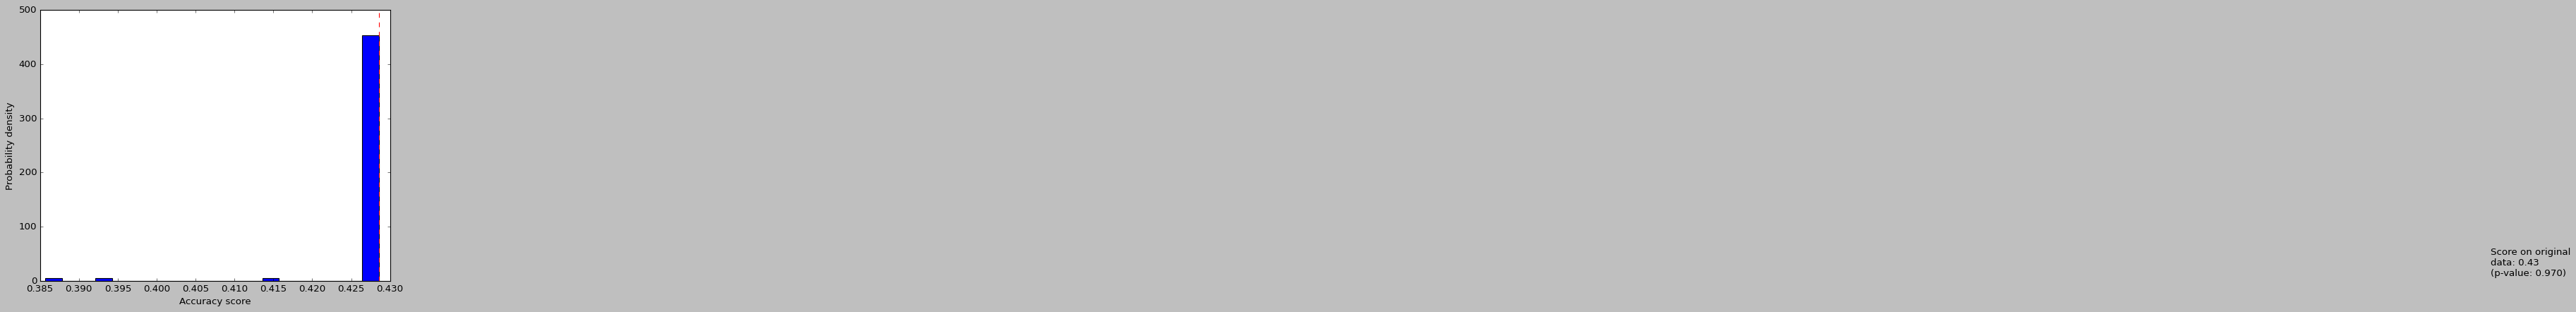

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability density")

In [134]:
AllPoints[56501 ]

array([[[31]],

       [[33]],

       [[25]]])

In [32]:
    
    #def MVPA_Classification(X,Y,Gr, pipeSpotLight):
    # '''Performe classification on voxel data'''
    SpotPerformance = 0;
    NRun=int(max(Gr))
    if (np.any(X)): # perform classifier if values of X are not all zero
        print(Gr)
        gkf = GroupKFold(n_splits=NRun) # leave one out, initialize GroupKFold with Nrun splits
        performance_this_fold = np.zeros(gkf.n_splits)
        for i_fold, (train_idx, test_idx) in enumerate(gkf.split(X=X, y=Y, groups=Gr)):
            if i_fold >=1:
                continue
            # print("Indices of our test-samples: %r" % test_idx.tolist())
            # print("... which correspond to following runs: %r" % Gr[test_idx].tolist(), '\n')
            # Implement your ToDo here!
            X_test, X_train=X[test_idx], X[train_idx]
            Y_test, Y_train=Y[test_idx], Y[train_idx]

            pipeSpotLight.fit(X_train, Y_train)
            preds = pipeSpotLight.predict(X_test)
            print('TRUE:',Y_test)
            print('Pred:',preds)
            print("Accuracy test: %.2f" % (preds == Y_test).mean())

            if len(list(set(Y)))>2: # for multi-class classifier
        #        performance = roc_auc_score(Y_test,  pipe.predict_proba(X_test), multi_class='ovr') # 'ovr'(One-vs-rest): Computes the AUC of each class against the rest, This treats the multiclass case in the same way as the multilabel case. Sensitive to class imbalance even when average == 'macro', because class imbalance affects the composition of each of the ‘rest’ groupings.
                # in the pairwise AUC calculation, if a sample is labeled wrongly as a another class (not in paired), it will be dropped from the calculation, resulting in a higher rate
                performance = roc_auc_score(Y_test,  pipeSpotLight.predict_proba(X_test),  multi_class='ovo', average = 'macro') # 'ovo' (One-vs-one) Computes the average AUC of all possible pairwise combinations of classes. Insensitive to class imbalance when average == 'macro'.
            else:
                performance = roc_auc_score(Y_test,  preds, average = 'macro') 

            performance_this_fold[i_fold] = performance
            print("ROC_AUC_Score: %.2f" % performance_this_fold[i_fold])

        SpotPerformance=np.mean(performance_this_fold)
        print(SpotPerformance)
        
    # return SpotPerformance


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
TRUE: [1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3.]
Pred: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3.]
Accuracy test: 0.43
ROC_AUC_Score: 0.54
0.10798611111111112


In [122]:
Test_Prob=pipeSpotLight.predict_proba(X_test)
[np.argmax(Test_Prob[:, [0,1]], axis=1),np.argmax(Test_Prob[:, [1,2]], axis=1),np.argmax(Test_Prob[:, [0,2]], axis=1)]


[array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], dtype=int64)]

0.75

In [110]:
roc_auc_score([1,1,1,2,2,2,2],[2,2,2,2,2,2,2])

0.5

In [33]:
summation=np.sum(Test_Probtt[:, [0,1]], axis=1)
Test_Probtt12=Test_Probtt[:, [0,1]]/summation[:, np.newaxis]
roc_auc_score(YTest_tt[0:6], Test_Probtt12[0:6])#, average = 'macro')

NameError: name 'Test_Probtt' is not defined

In [80]:
roc_auc = roc_auc_score(YTest_tt, Test_Probtt, multi_class='ovo')#, average = 'macro')
roc_auc

0.4305555555555555

In [91]:
sum(Test_Probtt[:,0:2],)

array([2.80821646, 2.71319032])

In [89]:
Test_Probtt[:,0:2]/sum
roc_auc12 = roc_auc_score(YTest_tt, Test_Probtt[:,0:2], multi_class='ovo')#, average = 'macro')
roc_auc12

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

In [34]:
roc_auc_score(Y_test,  pipeSpotLight.predict_proba(X_test),  multi_class='ovo', average = 'macro')

0.5399305555555556

In [35]:
performance_this_fold

array([0.53993056, 0.        , 0.        , 0.        , 0.        ])

In [ ]:
def MVPA_FeatureExtraction(ZstatInfoSubj,CLconditions,Alldata, myPoints,EEG_features=None):
    '''In this function features for a classifer is extracted based on the myPoints provided & EEG features'''
    
    cntAllData=0
    num_fMRI_features=myPoints.shape[-1]
    if EEG_features is not None:
        num_EEG_features=len(EEG_features)
    else:
        num_EEG_features=0
    num_feature=num_fMRI_features+num_EEG_features
    X=np.empty((0, num_feature), int) # the number of voxels in the spot light search + number of EEG_features
    Y=np.array([])    
    Gr=np.array([]) 
    for iRun in ZstatInfoSubj['Run']:
        #print(iRun)
        MyZstat=ZstatInfoSubj.loc[(ZstatInfoSubj['Run']==iRun)]
        MyZstat.reset_index(inplace = True, drop = True)
        #print(MyZstat)
        X_run=np.empty((0, num_feature), int)
        Y_run=np.array([])
        Gr_run=np.array([])
        for iCond,CondName in enumerate(CLconditions):
            #print(MyZstat[CondName][0])
            X_tmp = np.zeros((len(MyZstat[CondName][0]), num_feature))
            Y_tmp = np.zeros(len(MyZstat[CondName][0]))
            for MyInd,MyNii in enumerate(MyZstat[CondName][0]):
                # print(f'{MyInd},{MyNii}')
                MyFile=MyZstat['Folder'][0]+MyNii
                data=Alldata[cntAllData,:,:,:]
                cntAllData+=1

                sphereVal = data[np.int_(myPoints[0]),np.int_(myPoints[1]),np.int_(myPoints[2])] 

                X_tmp[MyInd,0:num_fMRI_features] = sphereVal
                Y_tmp[MyInd]=int(iCond)+1

                # Extract EEG feature data
                if EEG_features is not None:
    
                    EEG_data=[]
                    for my_EEG in EEG_features:
                        EEG_col=CondName+'_'+my_EEG
                        #print(EEG_col)
                        #print(MyZstat[EEG_col][0])                    
                        EEG_data.append(MyZstat[EEG_col][0][MyInd])
                        #print(f'{EEG_col} for {MyNii}: {EEG_data[-1]}')
                    X_tmp[MyInd,num_fMRI_features:] =EEG_data
                                
            X_run=np.concatenate((X_run,X_tmp),axis = 0)
            Y_run=np.concatenate((Y_run,Y_tmp),axis = 0)
            Gr_run=np.concatenate((Gr_run,np.repeat(iRun,Y_tmp.shape)),axis = 0)
            #print(Y.shape)
        X=np.concatenate((X,X_run),axis = 0)
        Y=np.concatenate((Y,Y_run),axis = 0)
        Gr=np.concatenate((Gr,Gr_run),axis = 0)
#     print(cntAllData)
    return X, Y, Gr
    
    
    
def MVPA_Classification(X,Y,Gr, pipeSpotLight):
    '''Performe classification on voxed data'''
    SpotPerformance = 0;
    NRun=int(max(Gr))
    if (np.any(X)): # perform classifier if values of X are not all zero
        # print(Gr)
        gkf = GroupKFold(n_splits=NRun) # leave one out, initialize GroupKFold with Nrun splits
        performance_this_fold = np.zeros(gkf.n_splits)
        for i_fold, (train_idx, test_idx) in enumerate(gkf.split(X=X, y=Y, groups=Gr)):
            # print("Indices of our test-samples: %r" % test_idx.tolist())
            # print("... which correspond to following runs: %r" % Gr[test_idx].tolist(), '\n')
            # Implement your ToDo here!
            X_test, X_train=X[test_idx], X[train_idx]
            Y_test, Y_train=Y[test_idx], Y[train_idx]

            pipeSpotLight.fit(X_train, Y_train)
            preds = pipeSpotLight.predict(X_test)
    #                 print('TRUE:',Y_test)
    #                 print('Pred:',preds)
    #                 print("Accuracy test: %.2f" % (preds == Y_test).mean())

            if len(list(set(Y)))>2: # for multi-class classifier
        #        performance = roc_auc_score(Y_test,  pipe.predict_proba(X_test), multi_class='ovr') # 'ovr'(One-vs-rest): Computes the AUC of each class against the rest, This treats the multiclass case in the same way as the multilabel case. Sensitive to class imbalance even when average == 'macro', because class imbalance affects the composition of each of the ‘rest’ groupings.
                # in the pairwise AUC calculation, if a sample is labeled wrongly as a another class (not in paired), it will be dropped from the calculation, resulting in a higher rate
                performance = roc_auc_score(Y_test,  pipeSpotLight.predict_proba(X_test),  multi_class='ovo', average = 'macro') # 'ovo' (One-vs-one) Computes the average AUC of all possible pairwise combinations of classes. Insensitive to class imbalance when average == 'macro'.
            else:
                performance = roc_auc_score(Y_test,  preds, average = 'macro') 

            performance_this_fold[i_fold] = performance

        SpotPerformance=np.mean(performance_this_fold)
        
    return SpotPerformance

def LoopiFeature(iFeature: int, AllPoints: np.ndarray,ZstatInfoSubj: pd.core.frame.DataFrame ,CLconditions: list, Alldata: np.ndarray, pipeSpotLight: Pipeline,EEG_features=None):
    myPoints = AllPoints[iFeature] 
    #myPoints = SpherePoints(np.array([30,30,15]) , radius,voxel_dims) # sample good point

    [X, Y, Gr]=MVPA_FeatureExtraction(ZstatInfoSubj,CLconditions,Alldata, myPoints,EEG_features) # extract data for classifer
    SpotPerformance=MVPA_Classification(X,Y,Gr, pipeSpotLight)
    return SpotPerformance

In [17]:
pipeSpotLight='pipeSpotLight'
SpotPerformance = 0;
NRun=int(max(Gr))

In [19]:
gkf = GroupKFold(n_splits=NRun)
performance_this_fold = np.zeros(gkf.n_splits)
gkf.n_splits

8

In [20]:
pipeSpotLight='pipeSpotLight'
SpotPerformance = 0;
NRun=int(max(Gr))
if (np.any(X)): # perform classifier if values of X are not all zero
    # print(Gr)
    gkf = GroupKFold(n_splits=NRun) # leave one out, initialize GroupKFold with Nrun splits
    performance_this_fold = np.zeros(gkf.n_splits)
    for i_fold, (train_idx, test_idx) in enumerate(gkf.split(X=X, y=Y, groups=Gr)):
        print("Indices of our test-samples: %r" % test_idx.tolist())
        print("... which correspond to following runs: %r" % Gr[test_idx].tolist(), '\n')
        # Implement your ToDo here!
        X_test, X_train=X[test_idx], X[train_idx]
        Y_test, Y_train=Y[test_idx], Y[train_idx]

        pipeSpotLight.fit(X_train, Y_train)
        preds = pipeSpotLight.predict(X_test)
#                 print('TRUE:',Y_test)
#                 print('Pred:',preds)
#                 print("Accuracy test: %.2f" % (preds == Y_test).mean())

#        performance = roc_auc_score(Y_test,  pipe.predict_proba(X_test), multi_class='ovr') # 'ovr'(One-vs-rest): Computes the AUC of each class against the rest, This treats the multiclass case in the same way as the multilabel case. Sensitive to class imbalance even when average == 'macro', because class imbalance affects the composition of each of the ‘rest’ groupings.
        # in the pairwise AUC calculation, if a sample is labeled wrongly as a another class (not in paired), it will be dropped from the calculation, resulting in a higher rate
        performance = roc_auc_score(Y_test,  pipeSpotLight.predict_proba(X_test),  multi_class='ovo', average = 'macro') # 'ovo' (One-vs-one) Computes the average AUC of all possible pairwise combinations of classes. Insensitive to class imbalance when average == 'macro'.

        performance_this_fold[i_fold] = performance

    SpotPerformance=np.mean(performance_this_fold)

Indices of our test-samples: [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151]
... which correspond to following runs: [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0] 



AttributeError: 'str' object has no attribute 'fit'

In [14]:
iFeature=74712

myPoints = DataArgDict['AllPoints'][iFeature] 
myPoints.shape
#LoopiFeatureDict(iFeature, DataArgDict)
[X, Y, Gr]=MVPA_FeatureExtraction(DataArgDict['ZstatInfoSubj'],DataArgDict['CLconditions'],DataArgDict['Alldata'], myPoints) # extract data for classifer
SpotPerformance=MVPA_Classification(X,Y,Gr, DataArgDict['pipeSpotLight'])
pipeSpotLight='pipeSpotLight'

In [17]:
# This code does classification based on spot light search, serial processing (for trouble shooting)
CLconditions=['Neu','Neg','Targ']


##LinearSVC(random_state=0))
clf = SVC(kernel='linear',probability=True)
pipeSpotLight = Pipeline([('scaler', StandardScaler()), ('clf', clf)])

# subj_list_one=[subj_list[1]]; 
# Nsubj=len(subj_list_one)
Nsubj=len([subj_list[6]])
all_performance = np.zeros(Nsubj)
for i_sub, subj in enumerate([subj_list[6]]):
    print(subj)
    start = timer()

    ZstatInfoSubj=ZstatInfo.loc[ZstatInfo['Subj']==subj]
    Zstattmp=ZstatInfoSubj.loc[ZstatInfoSubj['Run']==1]
    Zstattmp.reset_index(inplace = True, drop = True)
    MyFiletmp=Zstattmp['Folder'][0]+Zstattmp['Neg'][0][0]
    
    myimg_affine=nib.load(MyFiletmp).affine

    Alldata=LoadAllNii(ZstatInfoSubj,CLconditions) # load Alldata
         
    DataArgDict= {'AllPoints': AllPoints,
              'ZstatInfoSubj':ZstatInfoSubj ,
              'CLconditions': CLconditions, 
              'Alldata': Alldata,
              'pipeSpotLight':pipeSpotLight} 
    SpotLight_performance=np.zeros(AllPoints.shape[0])
    
#     aa1= range(AllPoints.shape[0])
#     aa2=[DataArgDict]*len(aa1)
#     aa=[*zip(aa1, aa2)]

    resultsN = np.zeros(AllPoints.shape[0])
    for iFeature in range(AllPoints.shape[0]): #iFeature=40836, range(56500,56610):
        if (iFeature==74712 and radius==2 and subj=='ET_12102013'): # for ET, radius=2, the code stucks at this voxel
            resultsN[iFeature]=resultsN[iFeature-1]
        else:
            resultsN[iFeature]= LoopiFeatureDict(iFeature, DataArgDict)
    
    resultsN=np.array(resultsN).reshape(voxel_dims)

    nft_img = nib.Nifti1Image(resultsN, myimg_affine)
    OutFile='C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/MRI_data/Analysis/MVPA/SpotlightR'+str(radius)+'/MVPA_'+subj+'.nii.gz'
    nib.save(nft_img, OutFile)

    end = timer()
    print(end-start)
# print(resultsN[56500:56510])

ET_12102013
6693.612897799991


In [2]:
OutFile

NameError: name 'OutFile' is not defined

In [41]:
Zstattmp=ZstatInfoSubj.loc[ZstatInfoSubj['Run']==1]
Zstattmp.reset_index(inplace = True, drop = True)
MyFile=Zstattmp['Folder'][0]+Zstattmp['Neg'][0][0]
data = nib.load(MyFile).get_data()
voxel_dims = data.shape
print(voxel_dims)

C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/MRI_data/Analysis/SPM/AM_05082014/3cond_dist2/run01/spmT_0009.nii


In [40]:
Zstattmp=ZstatInfoSubj.loc[ZstatInfoSubj['Run']==1]
Zstattmp.reset_index(inplace = True, drop = True)
Zstattmp

,Subj,Run,Folder,Neu,Neg,Pos,Targ
0,AM_05082014,1,C://Users/user/Documents/Reyhaneh/EEG+fMRI/EO/...,"[spmT_0001.nii, spmT_0002.nii, spmT_0003.nii, ...","[spmT_0009.nii, spmT_0010.nii, spmT_0011.nii, ...",[spmT_0017.nii],"[spmT_0018.nii, spmT_0019.nii, spmT_0020.nii, ..."


In [ ]:

MyFile=MyZstat['Folder'][0]+MyZstat['Neu'][0][0]
#print(MyFile)
data = nib.load(MyFile).get_data()
voxel_dims = data.shape
print(voxel_dims)

In [ ]:
statOut=np.array(resultsN).reshape(voxel_dims)
statOut.shape
nib.save(statOut)

In [ ]:
cnt=0
tmpVal=[]
for tmp in itertools.product(range(0,1), range(0,2), range(0,3)):
    print(f'{tmp}: {cnt}')
    tmpVal.append(cnt)
    cnt+=1
print(tmpVal)
tmpVal=np.array(tmpVal)
tt=tmpVal.reshape(1,2,3)
tt.shape

In [ ]:
tt[0,1,2]

In [ ]:
aa1= range(AllPoints.shape[0])
aa2=[DataArgDict]*len(aa1)
aa=[*zip(aa1, aa2)]

#def multi_run_wrapperLoopiFeatureDict(args): # If I call it here, Jupyter notebook will freeze
#    return LoopiFeatureDict(*args) 
start = timer()

if __name__ == "__main__":
    
    pool = Pool(multiprocessing.cpu_count())
    results = pool.map(multi_run_wrapperLoopiFeatureDict,aa)
    #print(results)
end = timer()
print(end-start)    
print(results[56500:56510])

If it is needed to modify a funciton and relaod it:

In [ ]:
#del multi_run_wrapperLoopiFeatureDict
#from MVPA_func import multi_run_wrapperLoopiFeatureDict
multi_run_wrapperLoopiFeatureDict = reload(sys.modules["MVPA_func"]).multi_run_wrapperLoopiFeatureDict  # reload() returns the new module
LoopiFeatureDict = reload(sys.modules["MVPA_func"]).LoopiFeatureDict  # reload() returns the new module


In [ ]:
SpotLight_performance[56500:56510]